# Sound celerity maps in the Gulf Stream area

This is a first exploration.
We focus on the global domain.


In [1]:
# import libraries

%matplotlib inline
from glob import glob
from netCDF4 import Dataset
#import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw

import sys
sys.path.append("../flow")
from utils import *

# load grid info
grd = grid()

# output files
ofiles = sorted(glob(grd._datadir+'*avg*.nc'))
ofile = ofiles[0]

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
vertical grid parameters found in /home/datawork-lops-osi/jgula/NESED/nesed_avg.00240.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -7.212308e+01, max=-5.827296e+01
lat_rho min= 3.412333e+01, max=4.373431e+01
h min= 2.000000e+01, max=5.543070e+03
Lxi = 999.030393 km, Leta = 800.473014 km


---

## Temperature

To warm up we first look at temperature

---

In [2]:
# load temperature
T = Dataset(ofile)['temp']
print T

<type 'netCDF4._netCDF4.Variable'>
float32 temp(time, s_rho, eta_rho, xi_rho)
    long_name: averaged potential temperature
    units: Celsius
    field: temperature, scalar, series
    standard_name: sea_water_potential_temperature
    coordinates: lat_rho lon_rho
unlimited dimensions: time
current shape = (20, 50, 1602, 2002)
filling off



---

## Horizontal map


Text(0.5,1,u'surface temperature [degC]')

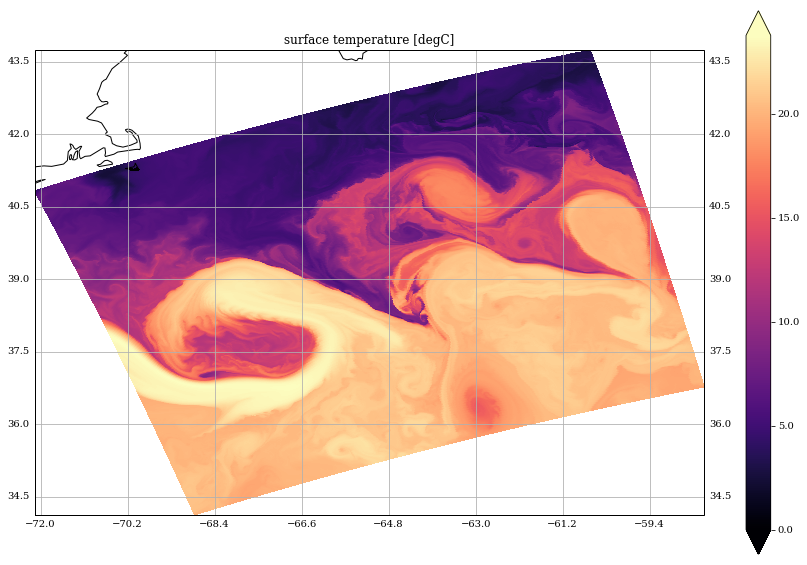

In [3]:
crs = ccrs.PlateCarree()

fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
ax.set_extent(grd.hextent, crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
it = 0
iz = -1
ilon = grd.Lp/2  # used for vertical slices
toplt = T[it,iz,:,:]
# should probably mask T
cmap = plt.get_cmap('magma')
im = ax.pcolormesh(grd.lon_rho,grd.lat_rho,toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_title('surface temperature [degC]')

#plt.savefig('figs/T_hmap.png',dpi=300)



---

## Vertical sections


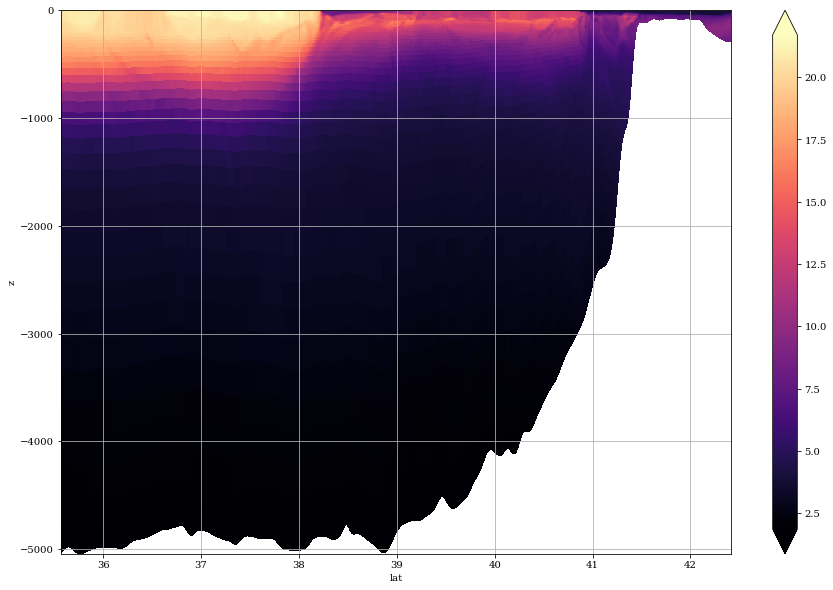

In [4]:
#ilon = grd.Lp/2
lat = grd.lat_rho[None,:,ilon]
h = grd.h[None,:,ilon]
zeta = Dataset(ofile)['zeta'][:][[it],:,ilon]
z = grd.get_z(zeta,h,grd.sc_r[:,None],grd.Cs_r[:,None])

plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = T[it,:,:,ilon]
im = ax.pcolormesh(lat,z,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.grid(True)

#plt.savefig('figs/T_latz.png',dpi=300)


---

## Start looking at sound celerity now

---

In [5]:

# derive surface sound speed
S = Dataset(ofile)['salt']
z = T[it,iz,:,:]*0.
c = get_soundc(T[it,iz,:,:], S[it,iz,:,:], z, grd.lon_rho, grd.lat_rho)

Text(0.5,1,u'sound speed [m/s]')

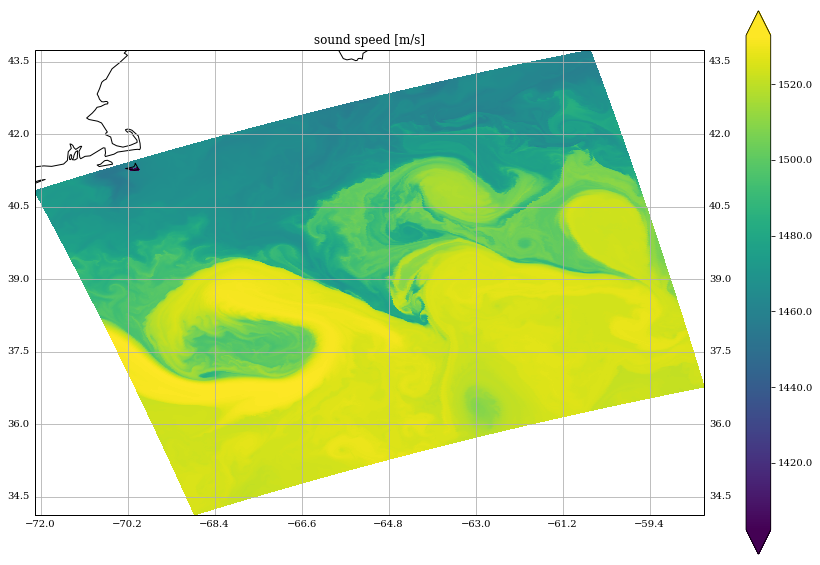

In [6]:
fig=plt.figure(figsize=(15,10))
#
ax=plt.axes(projection=crs)
ax.set_extent(grd.hextent, crs)
gl=ax.gridlines(crs=crs,draw_labels=True)
gl.xlabels_top = False
ax.coastlines(resolution='50m')
#
#it = 0
#iz = -1
#ilon = grd.Lp/2  # used for vertical slices
toplt = c
# should probably mask T
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(grd.lon_rho,grd.lat_rho,toplt,
                   vmin=toplt.min(),vmax=toplt.max(), 
                   cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_title('sound speed [m/s]')

#plt.savefig('figs/c_hmap.png',dpi=300)


---

### It is necessary to interpolate celerity on a uniform spatial grid

This is illustrated with the plot below which indicates variations of celerity at depth
that are not realistic.



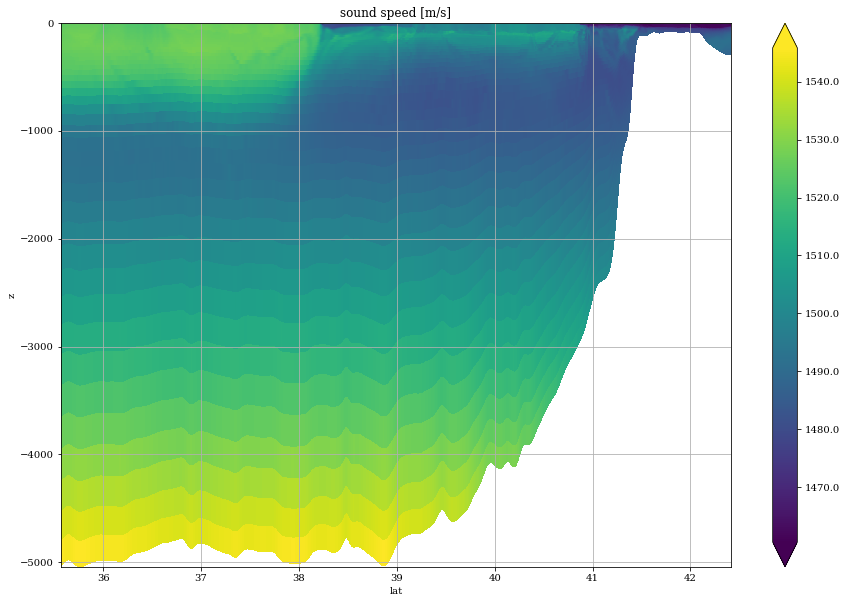

In [7]:
lon = grd.lon_rho[None,:,ilon]
lat = grd.lat_rho[None,:,ilon]
h = grd.h[None,:,ilon]
zeta = Dataset(ofile)['zeta'][:][[it],:,ilon]
z = grd.get_z(zeta,h,grd.sc_r[:,None],grd.Cs_r[:,None])
# derive surface sound speed
S = Dataset(ofile)['salt']
c = get_soundc(T[it,:,:,ilon], S[it,:,:,ilon], z, lon, lat)


plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = c
im = ax.pcolormesh(lat,z,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('sound speed [m/s]')
ax.grid(True)

#plt.savefig('figs/T_latz.png',dpi=300)

---

Deep fluctuations of velocity disapear if temperature and salinity are first interpolated on a horizontal uniform vertical grid


/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/gsw/gibbs/conversions.py:63: RuntimeWarning: invalid value encountered in greater
  cond1 = ((p < 100) & (SP > 120))
/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/gsw/gibbs/conversions.py:64: RuntimeWarning: invalid value encountered in greater
  cond2 = ((p >= 100) & (SP > 42))
/home1/homedir5/perso/aponte/.miniconda2/envs/cognac/lib/python2.7/site-packages/gsw/utilities/utilities.py:285: RuntimeWarning: invalid value encountered in less
  SA[SA < 0] = np.ma.masked


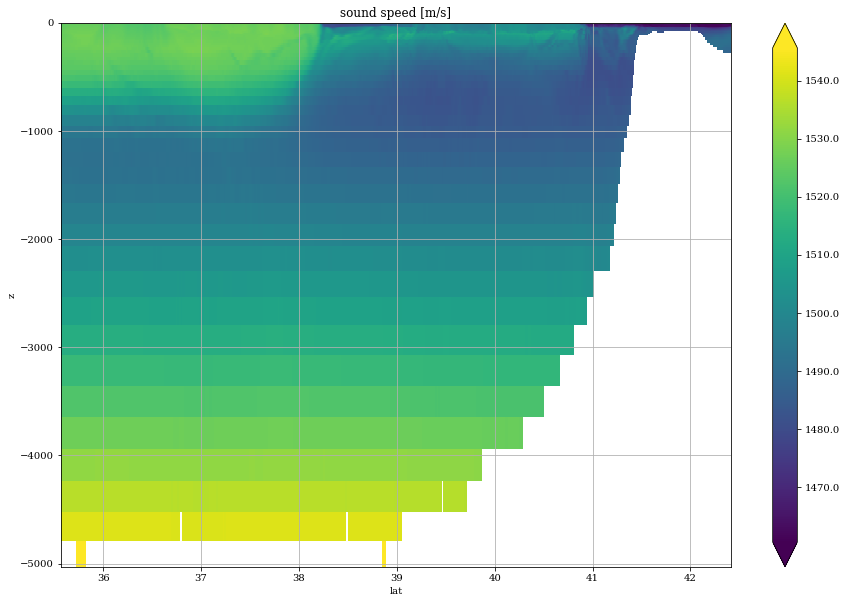

In [8]:
# interpolate on now a horizontally uniform grid

ilat=0
z_uni = z[:,ilat,None]
T_uni = interp2z0(z_uni, z[:,:,None], T[it,:,:,[ilon]])[:,:,0]
S_uni = interp2z0(z_uni, z[:,:,None], S[it,:,:,[ilon]])[:,:,0]
c_uni = get_soundc(T_uni, S_uni, z_uni, lon, lat)


plt.figure(figsize=(15,10))
ax=plt.subplot(111)
toplt = c_uni
im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('sound speed [m/s]')
ax.grid(True)


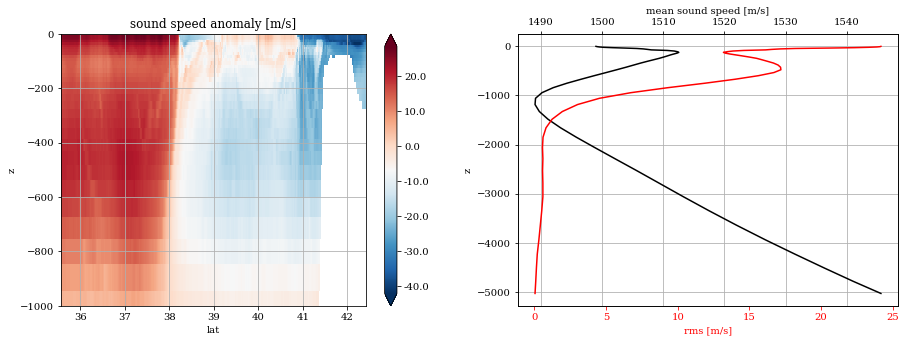

In [9]:
# show the anomaly with respect to the horizontally averaged profile

c_uni_mean = np.nanmean(c_uni,axis=1,keepdims=True)
c_uni_rms = np.nanstd(c_uni,axis=1,keepdims=True)

cmap = plt.get_cmap('RdBu_r')

plt.figure(figsize=(15,5))
ax=plt.subplot(121)
toplt = c_uni-c_uni_mean
im = ax.pcolormesh(lat,z_uni,toplt,cmap=cmap)
cbar = plt.colorbar(im, format='%.1f', extend='both')
ax.set_xlabel('lat')
ax.set_ylabel('z')
ax.set_title('sound speed anomaly [m/s]')
ax.grid(True)
ax.set_ylim([-1000.,0.])

ax=plt.subplot(122)
ax.plot(c_uni_mean,z_uni,'k')
ax.set_ylabel('z')
#ax.set_title('sound speed, mean [m/s]')
ax.set_xlabel('mean sound speed [m/s]')
ax.grid(True)
ax.xaxis.set_label_position('top') 

ax2 = ax.twiny()
ax2.plot(c_uni_rms,z_uni,'r')
ax2.set_xlabel('rms [m/s]', color='r')
ax2.tick_params('x', colors='r')
ax2.xaxis.set_label_position('bottom') 
ax2.xaxis.tick_bottom()

ax.xaxis.tick_top()

#plt.savefig('figs/C_latz.png',dpi=300)

---

---

---